In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import math
import datetime as dt
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import statistics as stats
import scipy
from scipy.stats.stats import pearsonr
from matplotlib import style
import warnings
import seaborn as sns
import requests
import bs4 as bs
import os
import csv
warnings.filterwarnings('ignore')

In [127]:
### SIMPLE LINEAR REGRESSION IN STOCKS ###

In [113]:
def plotLR(ticker):
    end = dt.datetime.now()
    #change the number after the days
    start = end - dt.timedelta(days=356*15)
    #ticker = 'AAPL'
    data = web.DataReader(ticker,'yahoo',start,end)
    df = data.reset_index()
    df1 = df[["Date","Adj Close"]]
    ''' This is to see if the security we are looking at
    presents a linear pattern in this case for ADJ Closing
    Price throughout a ten+ year span'''
    # Import matplotlib package for date plots
    import matplotlib.dates as mdates
    years = mdates.YearLocator() # Get every year
    yearsFmt = mdates.DateFormatter('%Y') # Set year format
    # Create subplots to plot graph and control axes
    fig, ax = plt.subplots()
    ax.plot(df1['Date'], df1['Adj Close'])
    # Format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    # Set figure title
    plt.title('Stock Price History [2009 - 2020]', fontsize=16)
    # Set x label
    plt.xlabel('Date', fontsize=14)
    # Set y label
    plt.ylabel('ADJ Close Stock Price', fontsize=14)
    # Rotate and align the x labels
    fig.autofmt_xdate()
    # Show plot
    plt.show()
    #Linear Regression (if the stock is trending up throughout lifespan)
    '''X is the dependent variable where it is date while 
    Y is the independent variable where it is the adjusted 
    close price of the security'''
    # Split the data into a train and test set (80 percent / 20 percent respectively)
    train, test = train_test_split(df1, test_size=0.20)
    # Reshape index column to 2D array for .fit() method
    X_train = np.array(train.index).reshape(-1, 1)
    y_train = train['Adj Close']
    # Create LinearRegression Object
    model = LinearRegression()
    # Fit linear model using the train data set
    model.fit(X_train, y_train)
    #Evaluate the model
    '''The slope coefficient: This exlpains that 
    for every day that goes by, the stock price 
    increases (or decreases) by the given value.
    The intercept coefficient: This is the ADJ close
    at date 0...'''
    # The coefficient
    print('Slope: ', np.asscalar(np.squeeze(model.coef_)))
    # The Intercept
    print('Intercept: ', model.intercept_)
    #Train set graph
    plt.figure(1, figsize=(16,10))
    #price to time linear regression
    plt.title('Linear Regression')
    plt.scatter(X_train, y_train, edgecolor='w', label='Actual ADJ Close')
    plt.plot(X_train, model.predict(X_train), color='r', label='Predicted ADJ Close')
    plt.xlabel('Days (Not Calendar)')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

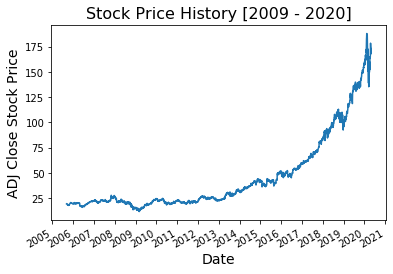

Slope:  0.02855405915317123
Intercept:  -7.597154743361294


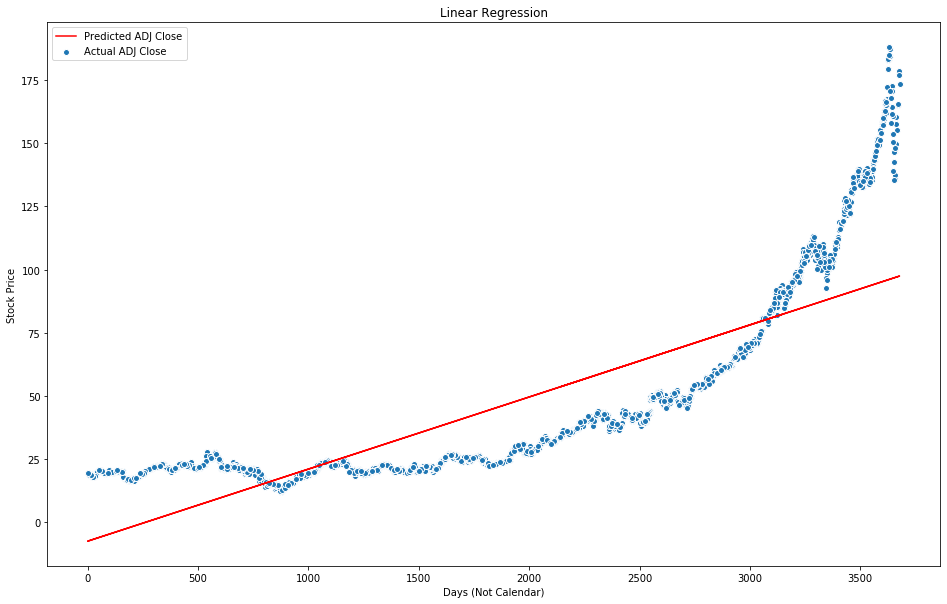

In [116]:
plotLR('MSFT')

In [111]:
def linearRegressionEquityPredictor(ticker):
    end = dt.datetime.now()
    #change the number after the days
    start = end - dt.timedelta(days=365*15)
    data = web.DataReader(ticker,'yahoo',start,end)
    df = data.reset_index()
    df1 = df[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
    #subtract out the last date for our prediction factor at the end
    df2 = df1.drop(df1.index[-1])
    X = df2.drop(['Date','Close'], axis=1, inplace=True)
    y = df2[['Adj Close']]
    #making dataframe into an array
    df3 = df2.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(df3, y, test_size=0.25,  random_state=0)
    regression_model = LinearRegression()
    regression_model.fit(X_train, y_train)
    intercept = regression_model.intercept_[0]
    print(f"The intercept for the model is {intercept}.")
    regression_model.score(X_test, y_test)
    from sklearn.metrics import mean_squared_error
    y_predict = regression_model.predict(X_test)
    regression_model_mse = mean_squared_error(y_predict, y_test)
    regression_model_mse
    math.sqrt(regression_model_mse)
    #given open, high, low, close, volume
    #predicts next day price
    latestOpen = df1.iloc[-1]['Open']
    latestHigh = df1.iloc[-1]['High']
    latestLow = df1.iloc[-1]['Low']
    latestClose = df1.iloc[-1]['Close']
    latestVolume = df1.iloc[-1]['Volume']
    prediction = regression_model.predict([[latestOpen, latestHigh, latestLow, latestClose, latestVolume]])
    print(f"Using a simple linear regression, {ticker}'s price will be {prediction} next trading day.")
    
### New regression model for predicting stock prices ###

def lr(ticker):
    '''This is different because it predicts the next 30 days. 
    Plan on testing it to linear stocks in different sectors'''
    end = dt.datetime.now()
    #change the number after the days
    start = end - dt.timedelta(days=365*15)
    #ticker = 'AAPL'
    data = web.DataReader(ticker,'yahoo',start,end)
    df = data[['Adj Close']]
    #create a variable for how many days out into the future
    forecast = 30
    #create a column for the target (dependent variable)
    #just shifting the adjusted close n days back
    df['Prediction'] = df['Adj Close'].shift(-forecast)
    #### create INDEPENDENT DATASET as X ######
    #### want it as a numpy array ######
    X = np.array(df.drop(['Prediction'],1))
    # remove last n amount of rows
    X = X[:-forecast]
    #### create the DEPENDENT DATASET as Y ######
    #### want it as a numpy array ######
    y = np.array(df['Prediction'])
    # getting all values except the forecasting rows
    y = y[:-forecast]
    #### splitting the data into the .8 training and .2 tetsing
    x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=.2)
    #### create support vector regresssor
    svrRBF = SVR(kernel = 'rbf', C = 1e3, gamma = .1)
    svrRBF.fit(x_train,y_train)
    #### Testing how good the support vector model really is #######
    svmConfidence = svrRBF.score(x_test,y_test)
    print(f'SVM confidence: {svmConfidence}')
    #### Create and train linear regression model ######
    lr = LinearRegression()
    # train model
    lr.fit(x_train,y_train)
    #### testing how good the linear regressior model really is #######
    lrConfidence = lr.score(x_test,y_test)
    print(f'lr confidence: {lrConfidence}')
    x_forecast = np.array(df.drop(['Prediction'],1))[-forecast:]
    print(x_forecast)
    #### Print linear regression model ######
    lrPrediction = lr.predict(x_forecast)
    print(lrPrediction)
    #### Support vector regressor model ######
    svmPrediction = svrRBF.predict(x_forecast)
    print(svmPrediction)

In [112]:
#linearRegressionEquityPredictor() is more accurate than lr() model
linearRegressionEquityPredictor('SPY')
#a low confidence is not good. A confidence of above .9 is good and should be a reasonable model
lr('SPY')

The intercept for the model is 2.0003454892503214e-08.
Using a simple linear regression, AAPL's price will be [[277.57998658]] next trading day.


In [2]:
### MORE MACHINE LEARNING MODELS THAT ARE MORE COMPLEX THAN LINEAR REGRESSION ###

In [137]:
#RSI and Stochastic Oscillator 
#I would like to see which produces better results
#The myRSI() or RSI() because i tweaked the equation to take into effect overall returns for each day
def myRSI(ticker):
    '''RSI can be used to see if a security is overbought
    or oversold. If the number is 30 or below, the stock 
    is believed to be oversold and this could be a buy
    signal. If it is 70-100, this is overbought and it could
    be a sell or short signal'''
    end = dt.datetime.now()
    # a year of trading
    start = end - dt.timedelta(days=365)
    # gaining the data from yahoo finance
    # ticker should be included as an argument when the function is called
    data = web.DataReader(ticker,'yahoo',start,end)
    # of high, low, close, adj close, and volume given, I only need adjusted close 
    df = data[['Adj Close']]
    # create a column called daily return
    df['Daily Return'] = df['Adj Close'].pct_change()*100
    # dataframe consists of 14 days because most RSI's are calculated in a 14 trading day span (15 for calculation purposes)
    df = df.iloc[-14:]
    # making a dataframe only for the percent return of each day
    df1 = df['Daily Return']
    # find days with positive and negative returns
    gain = df1[df1 > 0]
    loss = df1[df1 < 0]
    # average of all the days that were positive or negative 
    avgGain = (gain.sum()/14)
    avgLoss = (loss.sum()/14)
    RS = abs(avgGain/avgLoss)
    RSI = 100 - (100 / (1 + RS))
    #print(f'{ticker} has a myRSI: {RSI}')
    return RSI
    
### Standard RSI ###
def RSI(ticker):
    '''This is the traditional RSI where it only matters if
    a day experiences a positive or negative daily return.
    myRSI() differs by adding in a the fact that returns
    based on percentages (not booleans (pos or neg)) have an
    effect on the overall equation.'''
    end = dt.datetime.now()
    # a year of trading
    start = end - dt.timedelta(days=365)
    # gaining the data from yahoo finance
    # ticker should be included as an argument when the function is called
    data = web.DataReader(ticker,'yahoo',start,end)
    # of high, low, close, adj close, and volume given, I only need adjusted close 
    df = data[['Adj Close']]
    # create a column called daily return
    df['Daily Return'] = df['Adj Close'].pct_change()*100
    # dataframe consists of 14 days because most RSI's are calculated in a 14 trading day span (15 for calculation purposes)
    df = df.iloc[-14:]
    # making a dataframe only for the percent return of each day
    df['Up/Down'] = np.sign(df['Daily Return'])
    df1 = df['Up/Down']
    # find days with positive and negative returns
    gain = df1[df1 > 0]
    loss = df1[df1 < 0]
    # average of all the days that were positive or negative 
    avgGain = (gain.sum()/14)
    avgLoss = abs(loss.sum()/14)
    RS = (avgGain/avgLoss)
    RSI = 100 - (100 / (1 + RS))
    #print(f'{ticker} has an RSI of {RSI}')
    return RSI

In [138]:
myRSI('AUY')

93.00959869244733

In [139]:
RSI('AUY')

78.57142857142857

In [119]:
### RSI Stochastics ###
### The coolest one (you can see the whole data frame oscillate RSI back and forth from 30 to 80) ###

In [195]:
### 
def stochRSI(ticker,period):
    '''Input ticker('SPY') and period (amount of days) 
    Below 30 (50 for me) is a buy signal and above 80 is a sell or short signal
    When it is below 30, it is oversold, and when it is above 70, it is overbought'''
    end = dt.datetime.now()
    # print out the shape of the dataframe
    start = end - dt.timedelta(days=101)
    # gaining the data from yahoo finance
    # ticker should be included as an argument when the function is called
    data = web.DataReader(ticker,'yahoo',start,end)
    # of high, low, close, adj close, and volume given, I only need adjusted close 
    df = data[['Adj Close']]
    # create a column called daily return
    df['Daily Return'] = df['Adj Close'].pct_change()*100
    # making a dataframe only for the percent return of each day
    df['Up/Down'] = np.sign(df['Daily Return'])
    #drop the nan values
    df.dropna(inplace=True)
    # the returns that were up => display a 1 in the 'Up' Column
    df['Up']=(df['Up/Down']>0).astype(int)
    # the returns that were down => display a 1 in the 'Down' Column
    df['Down']=(df['Up/Down']<0).astype(int)
    ###create arrays for up and down columns to compute a rolling 14 day RSI###
    #could've done a for loop, but this was easier for me
    up = df['Up']
    down = df['Down']
    gain = pd.Series(up).rolling(window=period).sum()
    loss = pd.Series(down).rolling(window=period).sum()
    df['Gain'] = gain/period
    df['Loss'] = loss/period
    #create column for RS
    df['RS'] = df['Gain']/df['Loss']
    #create column for RSI
    df['RSI'] = 100 - (100/(1+df['RS']))
    #drop nan for no reason but I have ocd
    df.dropna(inplace=True)
    #trading period... 14 is standard but can try longer (might be better for most stocks I trade)
    df1 = df.iloc[-period:]
    maxRSI = df1['RSI'].max()
    minRSI = df1['RSI'].min()
    currentRSI = df1['RSI'][-1]
    RSIstoch = ((currentRSI - minRSI)/(maxRSI-minRSI))*100
    print(f'The current situation for {ticker} in a {period} day RSI Stochastic: {RSIstoch}')
    #test to see if data is correct / accurate
    print(df1)

### visualRSI is for dropping the RSI's into an excel file to see patterns ###    
    
def visualRSI(ticker):
    '''Coolest function... Can see the RSI values fluctuate (usually) from 20/30 to 70/80/90.
    Stocks that fluctuate and have good credit (or part of big indices) would be good picks 
    for trading strategy... below 50 is a buy indicator'''
    end = dt.datetime.now()
    # print out the shape of the dataframe
    start = end - dt.timedelta(days=365*3)
    # gaining the data from yahoo finance
    # ticker should be included as an argument when the function is called
    data = web.DataReader(ticker,'yahoo',start,end)
    # should have 29 rows
    print(data.shape)
    # of high, low, close, adj close, and volume given, I only need adjusted close 
    df = data[['Adj Close']]
    # create a column called daily return
    df['Daily Return'] = df['Adj Close'].pct_change()*100
    # making a dataframe only for the percent return of each day
    df['Up/Down'] = np.sign(df['Daily Return'])
    #drop the nan values
    df.dropna(inplace=True)
    df['Up']=(df['Up/Down']>0).astype(int)
    df['Down']=(df['Up/Down']<0).astype(int)
    up = df['Up']
    down = df['Down']
    gain = pd.Series(up).rolling(window=14).sum()
    loss = pd.Series(down).rolling(window=14).sum()
    df['Gain'] = gain/14
    df['Loss'] = loss/14
    df['RS'] = df['Gain']/df['Loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    df.dropna(inplace=True)
    #return RSI to an excel sheet to vizualize the RSI moving back and forth from below 50 to above 50
    df.to_excel(f'{ticker}StochasticRSIvisualization.xlsx')

In [194]:

stochRSI('VIG',14)

The current situation for VIG in a 14 day RSI Stochastic: 50.00000000000002
             Adj Close  Daily Return  Up/Down  Up  Down      Gain      Loss  \
Date                                                                          
2020-04-03  100.519997     -1.354274     -1.0   0     1  0.428571  0.571429   
2020-04-06  107.169998      6.615601      1.0   1     0  0.428571  0.571429   
2020-04-07  106.750000     -0.391899     -1.0   0     1  0.428571  0.571429   
2020-04-08  109.889999      2.941451      1.0   1     0  0.500000  0.500000   
2020-04-09  111.330002      1.310404      1.0   1     0  0.571429  0.428571   
2020-04-13  109.580002     -1.571903     -1.0   0     1  0.571429  0.428571   
2020-04-14  113.050003      3.166637      1.0   1     0  0.571429  0.428571   
2020-04-15  110.559998     -2.202570     -1.0   0     1  0.500000  0.500000   
2020-04-16  111.269997      0.642184      1.0   1     0  0.500000  0.500000   
2020-04-17  114.540001      2.938801      1.0   1     0

In [ ]:
visualRSI('XLK')

In [1]:
### Simple Machine Learning With TensorFlow ###

In [43]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

def kerasSimpleML(ticker):
    end = dt.datetime.now()
    start = end - dt.timedelta(days=365*3)
    #ticker = 'AAPL'
    df = web.DataReader(ticker,'yahoo',start,end)
    df['Open_Close'] = (df['Open'] - df['Adj Close'])/df['Open']
    df['High_Low'] = (df['High'] - df['Low'])/df['Low']
    df['Increase_Decrease'] = np.where(df['Volume'].shift(-1) > df['Volume'],1,0)
    df['Buy_Sell_on_Open'] = np.where(df['Open'].shift(-1) > df['Open'],1,0)
    df['Buy_Sell'] = np.where(df['Adj Close'].shift(-1) > df['Adj Close'],1,0)
    df['Returns'] = df['Adj Close'].pct_change()
    df = df.dropna()
    mod = tf.keras.Sequential([keras.layers.Dense(units=1, input_shape=[1])])
    mod.compile(optimizer='sgd', loss='mean_squared_error')
    # Feature
    X = np.array(df['Returns'], dtype = float) 
    # Target
    Y = np.array(df['Adj Close'], dtype = float) 
    #run 100 iterations on the dataset
    #data should be normalized if the value returned is NaN
    iterMod = mod.fit(X, Y, epochs=100)
    print(f'The first prediction of this model for {ticker} is {mod.predict([0])}')
    #need the amount of rows for the next step
    print(df.shape)
    scaler = MinMaxScaler()
    ### THE COLUMN NUMBER CHANGES ###
    normalized_X = scaler.fit_transform(np.array(df['Returns']).reshape(754,-1))
    X = np.array(normalized_X, dtype = float)
    normalized_Y = scaler.fit_transform(np.array(df['Adj Close']).reshape(754,-1))
    Y = np.array(normalized_Y, dtype = float)
    print(X.shape)
    print(Y.shape)

def build_model():
    mod = keras.Sequential([
    #layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    #layers.Dense(64, activation=tf.nn.relu),
    #layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    mod.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return mod

print(f'The prediction close for this equity is {mod.predict([0])}')

The prediction close for this equity is [[195.12039]]


In [39]:
build_model()